In [1]:
from datasets import load_dataset, Audio, concatenate_datasets
from IPython import display
import zlib
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from compressai.models import CompressionModel
from compressai.entropy_models import EntropyBottleneck
from compressai.ops.parametrizers import NonNegativeParametrizer
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from transformers import EncodecModel, AutoProcessor

2024-03-31 10:57:19.477608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 10:57:19.477653: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 10:57:19.480094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset = load_dataset("danjacobellis/aria_ea_audio").with_format("torch")
dataset = concatenate_datasets([dataset[key] for key in dataset.keys()])
def preprocess(sample):
    x = sample['audio'].to(torch.float)
    xr = x.transpose(0, 1).unsqueeze(0)
    num_channels = xr.size(1)
    kernel_size = 33
    kernel = torch.ones(num_channels, 1, kernel_size) / kernel_size
    smoothed_signal = F.conv1d(xr, kernel, padding='same', groups=num_channels)
    smoothed_signal = smoothed_signal.squeeze(0).transpose(0, 1)
    filtered_signal = x - smoothed_signal
    scaled_signal = (filtered_signal/(2**23)).tanh()
    sample['audio'] = scaled_signal
    return sample
preprocessed_dataset = dataset.map(preprocess, writer_batch_size=400)

In [3]:
x = preprocessed_dataset[0]['audio']

In [4]:
x.shape

torch.Size([300000, 7])

(-0.2, 0.2)

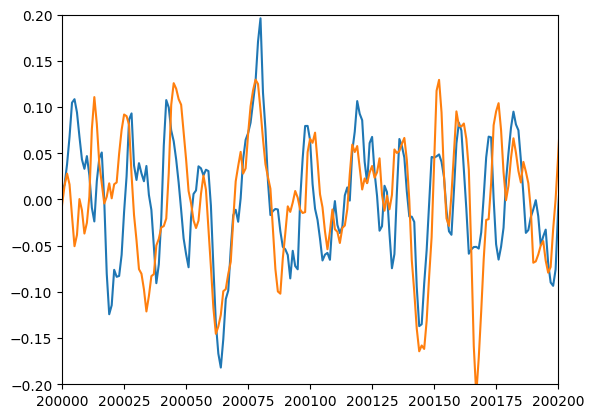

In [5]:
for channel in [0,2]:
    plt.plot(x[:,channel])
plt.xlim([200000,200200]);
plt.ylim([-0.2,0.2])

In [6]:
def analysis_1d(in_channels, out_channels, kernel_size=3, stride=2):
    return nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )

In [7]:
def synthesis_1d(in_channels, out_channels, kernel_size=3, stride=2):
    return nn.ConvTranspose1d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )

In [8]:
class GDN_1d(nn.Module):

    def __init__(
        self,
        in_channels: int,
        inverse: bool = False,
        beta_min: float = 1e-6,
        gamma_init: float = 0.1,
    ):
        super().__init__()

        beta_min = float(beta_min)
        gamma_init = float(gamma_init)
        self.inverse = bool(inverse)

        self.beta_reparam = NonNegativeParametrizer(minimum=beta_min)
        beta = torch.ones(in_channels)
        beta = self.beta_reparam.init(beta)
        self.beta = nn.Parameter(beta)

        self.gamma_reparam = NonNegativeParametrizer()
        gamma = gamma_init * torch.eye(in_channels)
        gamma = self.gamma_reparam.init(gamma)
        self.gamma = nn.Parameter(gamma)

    def forward(self, x: Tensor) -> Tensor:
        _, C, _ = x.size()

        beta = self.beta_reparam(self.beta)
        gamma = self.gamma_reparam(self.gamma)
        gamma = gamma.reshape(C, C, 1)
        norm = F.conv1d(x**2, gamma, beta)

        if self.inverse:
            norm = torch.sqrt(norm)
        else:
            norm = torch.rsqrt(norm)

        out = x * norm

        return out

In [9]:
class RateDistortionAutoEncoder(CompressionModel):
    def __init__(self, N=128):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            analysis_1d(7, N),
            GDN_1d(N),
            analysis_1d(N, N),
            GDN_1d(N),
            analysis_1d(N, N),
        )

        self.decode = nn.Sequential(
            synthesis_1d(N, N),
            GDN_1d(N, inverse=True),
            synthesis_1d(N, N),
            GDN_1d(N, inverse=True),
            synthesis_1d(N, 7),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [10]:
def lossy_analysis_transform(x):
    z = net.encode(x).round().to(torch.int8).detach().numpy()
    return z
    
def lossless_entropy_encode(z):
    original_shape = z.shape
    compressed_signal = zlib.compress(z.tobytes(), level=9)
    return compressed_signal, original_shape

def compress(signal):
    z = lossy_analysis_transform(signal)
    compressed_signal, original_shape = lossless_entropy_encode(z)
    return compressed_signal, original_shape

In [11]:
def entropy_decoder(compressed_signal,original_shape):
    decompressed = zlib.decompress(compressed_signal)
    ẑ = np.frombuffer(decompressed, dtype=np.int8)
    ẑ = ẑ.reshape(original_shape)
    return ẑ
    
def synthesis_transform(ẑ):
    ẑ = torch.tensor(ẑ).to(torch.float)
    x̂ = net.decode(ẑ).detach()
    return x̂
    
def decompress(compressed_signal, original_shape):
    ẑ = entropy_decoder(compressed_signal,original_shape)
    x̂ = synthesis_transform(ẑ)
    return x̂

In [12]:
net = RateDistortionAutoEncoder()
checkpoint = torch.load("checkpoint.pth")
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

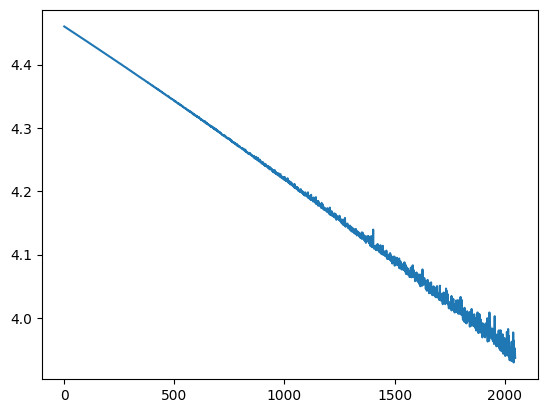

In [13]:
rate = np.load("rate.npy")
plt.plot(np.log(rate))

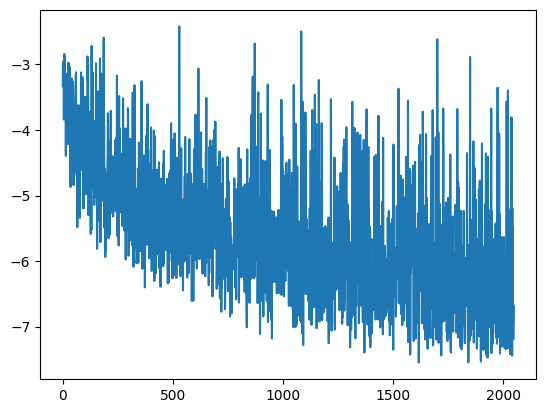

In [14]:
distortion = np.load("distortion.npy")
plt.plot(np.log(distortion))

In [41]:
x = preprocessed_dataset[5]['audio'].permute(1,0).to(torch.float).unsqueeze(0)
compressed_signal, original_shape = compress(x)
x̂ = decompress(compressed_signal,original_shape)

In [42]:
display.Audio(x[0][0],rate=48000)

In [45]:
display.Audio(x̂[0][0],rate=48000)

(15500.0, 16500.0)

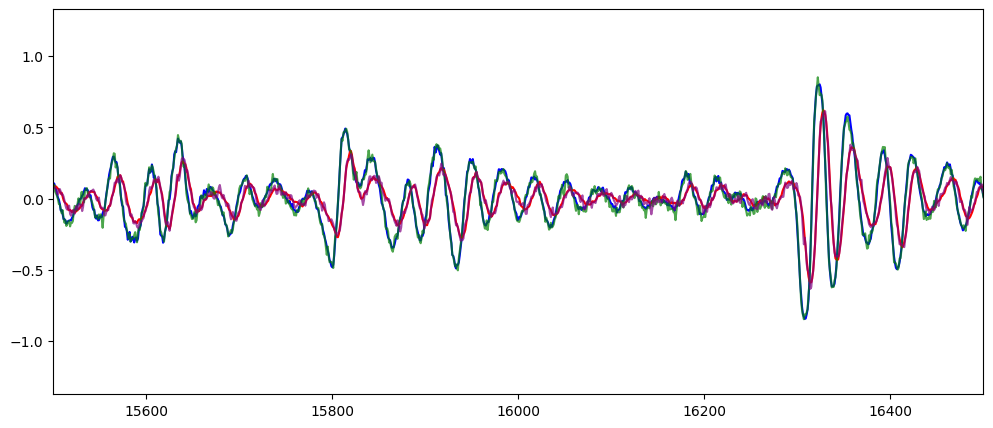

In [72]:
plt.figure(figsize=(12,5),dpi=100)
plt.plot(x[0][0],alpha=1,color='blue')
plt.plot(x[0][1],alpha=1,color='red')
plt.plot(x̂[0][0],alpha=0.7,color='green')
plt.plot(x̂[0][1],alpha=0.7,color='purple')
plt.xlim([15500,16500])

In [73]:
(32*7*48000*6.5)/len(compressed_signal)

112.7524054749966